# Fasting Blood Sugar Level & Maximum Heart Rate vs. Presence of Coronary Heart Disease

## Introduction

Coronary heart disease results from cholesterol accumulation in the walls of arteries (Centers for Disease Control and Prevention, 2021). Over time, this plaque buildup causes the arteries to constrict, blocking blood flow and leading to the condition. In individuals with heart disease, factors like blood sugar and heart rate have important connections to disease development. For example, high blood sugar levels can result in increased artery damage and higher plaque buildup on artery walls. Abnormal heart rate is also considered a risk factor for coronary heart disease, as it can indicate an increased need for oxygen associated with restricted arteries (LeWine, 2023). 

For this reason, we will be determining if fasting blood sugar, a measurement of blood sugar after fasting overnight (mg/dl),  and maximum heart rate achieved during exercise can predict the presence of coronary heart disease (bpm), using the dataset “Heart Disease” provided by the course. These variables were chosen as predictors based on previous research linking them to heart disease risk. Additionally, they are relatively accessible for a general population to obtain measurements and assess their own risk of heart disease based on the outcome of this analysis. 

Within this data set, patients’  fasting blood sugar (mg/dl) and their maximum heart rate reached during exercise (bpm) will be used as the predictors. This dataset includes patient information from research across four locations: the USA (Cleveland and Long Beach), Hungary, and Switzerland. We will only be using data from Cleveland. 

## Preliminary exploratory data analysis

In [2]:
library(tidyverse) #for data wrangling
library(repr) #for data visualizing
library(tidymodels) #for modeling
install.packages("kknn")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [3]:
set.seed(1)
download.file("https://raw.githubusercontent.com/shellumang/dsci-100-2023w1-group-28/main/processed.cleveland%5B1%5D.data", destfile = "processed.cleveland.data")
cleveland <- read_csv("processed.cleveland.data")
colnames(cleveland) = c("age","sex","cp","trestbps", "chol","fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num") #column headers come from dataset website
cleveland$num <- ifelse(cleveland$num>0, 1, 0) #This line of code converts all values > 1 in num to just 1, in order to binarize it.
processed_cleveland <- select(cleveland, fbs, thalach, num) |> #we only care about fbs, thalach, num
                mutate(fbs = as_factor(fbs)) |> #we consider fbs as a predictor categorical variable
                mutate(num = as_factor(num)) #we consider num as a goal categorical variable
head(processed_cleveland) #data after first round of processing

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fbs,thalach,num
<fct>,<dbl>,<fct>
0,108,1
0,129,1
0,187,0
0,172,0
0,178,0
0,160,1


The first round of processing involves reading in the data, and setting the column names of the dataset. We then select the three relevant columns for our analysis, "fbs"(fasting blood sugar level <= 120?),"thalach"(maximum heart rate achieved), and "num"(severity of heart disease). Then, for the specific case of the "num" column, binarizing the data in by setting all values above or equal to 1 and all values at 0 to stay at 0. This way, "num" now represents the binary variable "has heart disease?". We also changed the type of variables in the  "fbs" and "num" columns to factors because we are treating them as categorical variables for this analysis.

In [4]:
split_cleveland <- initial_split(processed_cleveland, prop = 0.75, strata = num) #this step is splitting the data into 75% training, 25% test
trainingdata <- training(split_cleveland) 
testingdata <- testing(split_cleveland)
head(trainingdata) #training data
head(testingdata) #testing data

fbs,thalach,num
<fct>,<dbl>,<fct>
0,187,0
0,172,0
0,178,0
0,153,0
0,173,0
0,160,0


fbs,thalach,num
<fct>,<dbl>,<fct>
0,160,1
0,163,0
0,148,0
1,162,0
0,174,0
0,139,0


This step subsets the dataset into training and testing datasets. We used the common split of 75% to 25% training data : testing data. We can see from the head() of both that the data has indeed been split and both test and training contain different data.

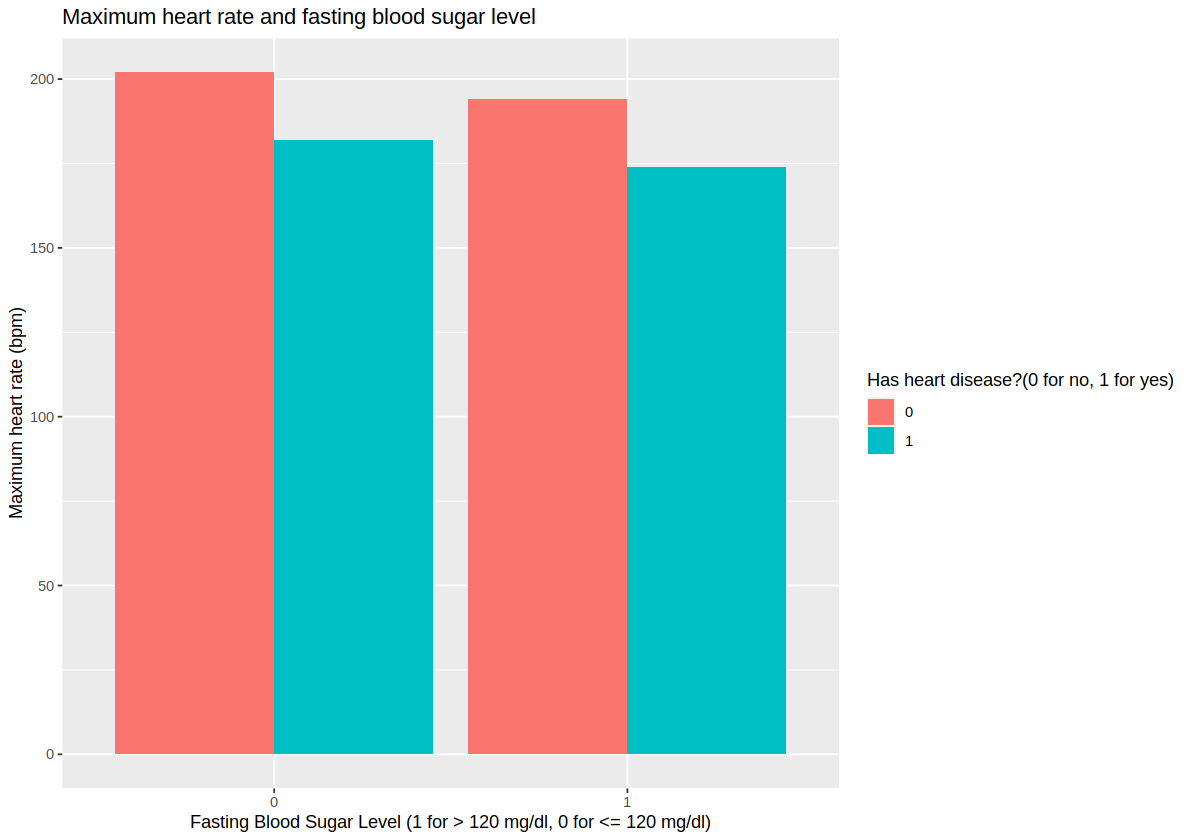

In [5]:
options(repr.plot.width = 10, repr.plot.height = 7) #for visualizing only
plot <- ggplot(trainingdata, aes(x = fbs, y = thalach, fill = num)) + 
geom_bar(position = "dodge", stat = "identity") + 
labs(x = "Fasting Blood Sugar Level (1 for > 120 mg/dl, 0 for <= 120 mg/dl)", y = "Maximum heart rate (bpm)", fill = "Has heart disease?(0 for no, 1 for yes)") +
ggtitle("Maximum heart rate and fasting blood sugar level")
plot

A quick preliminary bar graph shows us that for all fasting blood sugar levels, on average the people without heart disease have a faster maximum heart rate achieved during the exercise period.

## Methods

Our first predictor is variable #16 (fbs) which is the patient's fasting blood sugar level. Our second predictor is variable #32 (thalach) which is the patient maximum heart rate achieved during exercise (bpm). We will be using these to predict and classify variable #58 (num) which is the diagnosis of heart disease (angiographic disease status), with those having greater than 120 mg/dl fbs and/or low maximum heart rate being more likely to have heart disease. Note that for variable #58, we will be splitting the class into whether an individual does not have heart disease (num = 0) or has some heart disease (num >= 0). We will also only be using USA data from the Cleveland database for our analysis. To visualize the data, we will graph our results in a bar plot with maximum heart rate on the y-axis and fasting blood sugar on the x-axis, with bars organized by colour based on whether or not individuals are diagnosed with heart disease. 

Firstly, we perform cross-validation on the training data set to select which k is the most optimal for our data set for k-nn classification. 

In [6]:
recipe <- recipe(num ~ thalach + fbs, data = trainingdata)

vfold <- vfold_cv(trainingdata, v = 5, strata = num)

tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

values <- tibble(neighbors = seq(2,14,1))

knn_results <- workflow() |>
      add_recipe(recipe) |>
      add_model(tune) |>
      tune_grid(resamples = vfold, grid = values) |>
      collect_metrics() |>
      filter(.metric == "accuracy")
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.5844796,5,0.02798583,Preprocessor1_Model01
3,accuracy,binary,0.6819939,5,0.03814096,Preprocessor1_Model02
4,accuracy,binary,0.6560035,5,0.04612727,Preprocessor1_Model03
5,accuracy,binary,0.6071014,5,0.03740809,Preprocessor1_Model04
6,accuracy,binary,0.6421695,5,0.02267620,Preprocessor1_Model05
7,accuracy,binary,0.6553140,5,0.02908658,Preprocessor1_Model06
8,accuracy,binary,0.6686473,5,0.02559388,Preprocessor1_Model07
9,accuracy,binary,0.6510672,5,0.03681205,Preprocessor1_Model08
10,accuracy,binary,0.6553184,5,0.04156640,Preprocessor1_Model09


We created a recipe to predict "num" with the other variables, then set the "neighbors" argument in nearest_neighbor() to tune(). After collecting metrics, it gives us the above table which displays the accuracy per number of neighbours, which we will now graph to choose our value of k.

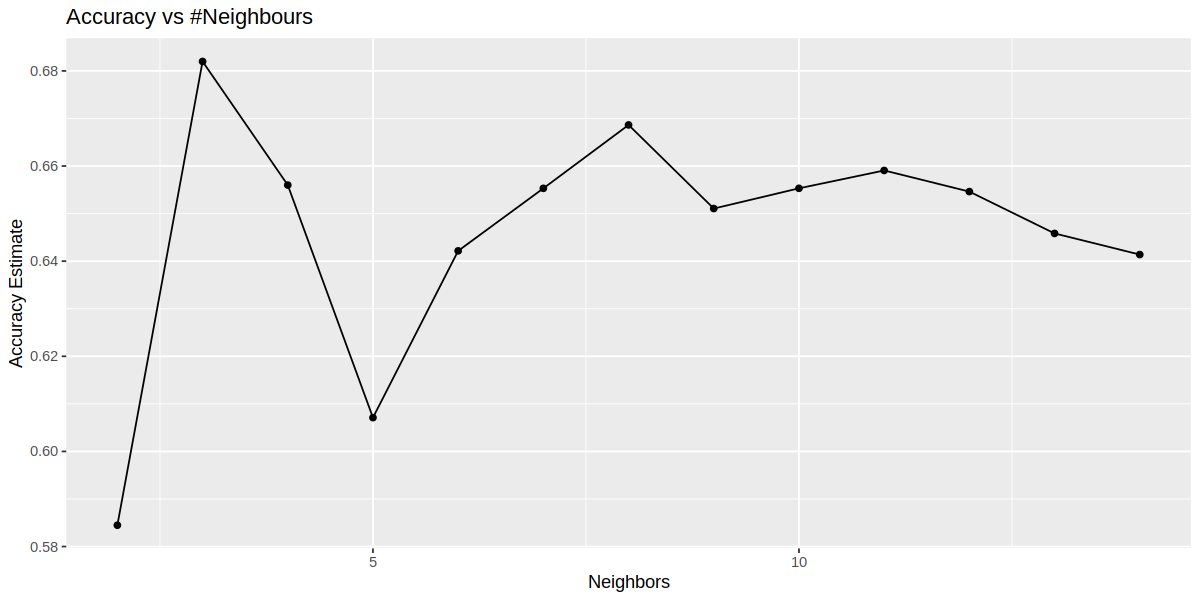

In [7]:
options(repr.plot.width = 10, repr.plot.height = 5) #for visualizing only
accuracy_versus_k <- ggplot(knn_results, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
ggtitle("Accuracy vs #Neighbours")
accuracy_versus_k

We can see that the most accurate predictions come from using k = 7, so we can now build our final model:

In [11]:
best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
      set_engine("kknn") |>
      set_mode("classification")

heart_fit <- workflow() |>
      add_recipe(recipe) |>
      add_model(best_spec) |>
      fit(data = trainingdata)

We can now use our final model to predict on the test dataset.

In [19]:
heart_predictions <- heart_fit |>
predict(testingdata) |>
bind_cols(testingdata)

heart_metrics <- heart_predictions |>
        metrics(truth = num, estimate = .pred_class)       |>
filter(.metric == "accuracy")

heart_metrics

heart_conf_mat <- heart_predictions |>
conf_mat(truth = num, estimate = .pred_class)    

heart_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6578947


          Truth
Prediction  0  1
         0 32 17
         1  9 18

## Results and Discussion

Model Performance: 

The accuracy of the binary classification model is approximately 65.79%.

Confusion Matrix:

The confusion matrix is presented in a 2x2 format, where the rows represent the actual classes, and the columns represent the predicted classes.
In the confusion matrix:
True Positives (TP): 18 instances were correctly predicted as class 1.
True Negatives (TN): 32 instances were correctly predicted as class 0.
False Positives (FP): 17 instances were incorrectly predicted as class 1.
False Negatives (FN): 9 instances were incorrectly predicted as class 0.
Interpretation:

The model has a reasonable accuracy, but it seems to have some difficulty correctly predicting instances of class 1, as indicated by the higher number of false positives and false negatives.

## Expected outcomes and significance

High blood sugar can result in increased buildup on artery walls and a low maximum heart rate can indicate abnormal heart function (Park et al., 2013; Sandvik et al., 1995). For this reason, we expect that individuals with higher fasting blood sugar and lower maximum heart rate achieved during exercise will be expected to have coronary heart disease (num >= 0). 
These findings could help people who have abnormally high fasting blood sugar or low maximum heart rates to understand the risks associated with these conditions. This could then encourage them to change their lifestyles in order to decrease their chances of developing heart disease. The outcome of this analysis could lead to questions about how to decrease fasting blood sugar levels, potentially through better monitoring of the timing of food consumption and types of food eaten.

## Discussion

summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?

## References

Centers for Disease Control and Prevention. (2022, June 20). Diabetes and your heart. Centers for Disease Control and Prevention. https://www.cdc.gov/diabetes/library/features/diabetes-and-heart.html#:~:text=Over%20time%2C%20high%20blood%20sugar,and%20can%20damage%20artery%20walls 
Coronary artery disease. Centers for Disease Control and Prevention. (2021, July 19). https://www.cdc.gov/heartdisease/coronary_ad.htm#:~:text=Coronary%20artery%20disease%20is%20caused,This%20process%20is%20called%20atherosclerosis

Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J. J., Sandhu, S., Guppy, K. H., Lee, S., & Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. The American journal of cardiology, 64(5), 304–310. https://doi.org/10.1016/0002-9149(89)90524-9

Diabetes tests. Centers for Disease Control and Prevention. (2023, February 28). https://www.cdc.gov/diabetes/basics/getting-tested.html#:~:text=Fasting%20Blood%20Sugar%20Test,higher%20indicates%20you%20have%20diabetes

LeWine, H. E. (Ed.). (2023, June 13). What your heart rate is telling you. Harvard Health. https://www.health.harvard.edu/heart-health/what-your-heart-rate-is-telling-you#:~:text=It%20speeds%20up%20and%20slows,disease%20or%20other%20medical%20condition 

Park, C., Guallar, E., Linton, J. A., Lee, D.-C., Jang, Y., Son, D. K., Han, E.-J., Baek, S. J., Yun, Y. D., Jee, S. H., & Samet, J. M. (2013). Fasting glucose level and the risk of incident atherosclerotic cardiovascular diseases. Diabetes Care, 36(7), 1988–1993. https://doi.org/10.2337/dc12-1577

Sandvik, L., Erikssen, J., Ellestad, M., Erikssen, G., Thaulow, E., Mundal, R., & Rodahl, K. (1995). Heart rate increase and maximal heart rate during exercise as predictors of cardiovascular mortality. Coronary Artery Disease, 6(8), 667–679. https://doi.org/10.1097/00019501-199508000-00012